# Classical causal inference approaches for observational data with `DoWhy`

In this notebook, we provide a complete overview of the causal inference pipeline with the Python package [`DoWhy`](https://www.pywhy.org/dowhy/v0.10.1/).

This notebook takes up and enriches the code examples from the book. To execute the code, you will need to install `DoWhy` and `econml`, ideally in a virtual environment to avoid any compatibility problems. This will also install other packages required here.

In [1]:
%%capture

!pip install dowhy
!pip install econml
!pip install pygraphviz

Let's import first the packages we will need here.

In [2]:
import dowhy
import dowhy.datasets
from dowhy import CausalModel
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegressionCV


# you may want to filer out some warnings as there is some
# issue with the parameters used at the time of writing
import warnings
warnings.filterwarnings("ignore")

print(dowhy.__version__, np.__version__, sklearn.__version__)

0.10.1 1.23.5 1.2.2


## Data generation and establishing identifiability

To move forward, we need to generate simulated data to play with. You may want to change some characteristics of the dataset. In `DoWhy`, the treatment(s) are denoted `v?`

Here are some parameters of the function `dowhy.dataset.linear_dataset` to adjust to experiment
- `beta`: coefficient of the treatment(s) (`v?`) in the generating equation of the outcome (`y`)
- `num_samples`: number of observations in the dataset

Then you can influence the shape of the causal graph underlying the data generating process. Here are the main parameters to set, and you can check the documentation for more advanced options
- `num_common_causes`: Number of variables affecting both the treatment and the outcome, denoted `W?` (confounders)
- `num_instruments`: Number of instrumental variables affecting only the treatment, denoted `Z?`  [z -> v]
- `num_effect_modifiers`: Number of effect modifiers, variables affecting only the outcome [x -> y]


The function outputs a dictionary that includes the data as a dataframe, the names of several relevant groups of variables (treatment(s), outcome, common causes....), and the graph.

In [3]:
# Set a seed for reproducibility
np.random.seed(18)
# Create a synthetic dataset. Note:
data = dowhy.datasets.linear_dataset(
    num_common_causes=5,
    num_instruments = 1,
    num_effect_modifiers=1,
    treatment_is_binary=True,
    num_samples=3000,
    num_discrete_common_causes=1,
    beta=10,stddev_treatment_noise=10)

The first step of causal analysis with `DoWhy` is to create a [`CausalModel`](https://www.pywhy.org/dowhy/v0.8/dowhy.html#dowhy.causal_model.CausalModel) object. Here we will use our simulated dataset, but you could use any data by specifying the graph. A `CausalModel` object has very useful methods that we will use to conduct our analysis.

In [4]:
# create a CausalModel object
model = CausalModel(data=data['df'],
                    treatment=data['treatment_name'],
                    outcome=data['outcome_name'],
                    graph=data["gml_graph"])

First, we can visualize the causal graph underlying our problem.

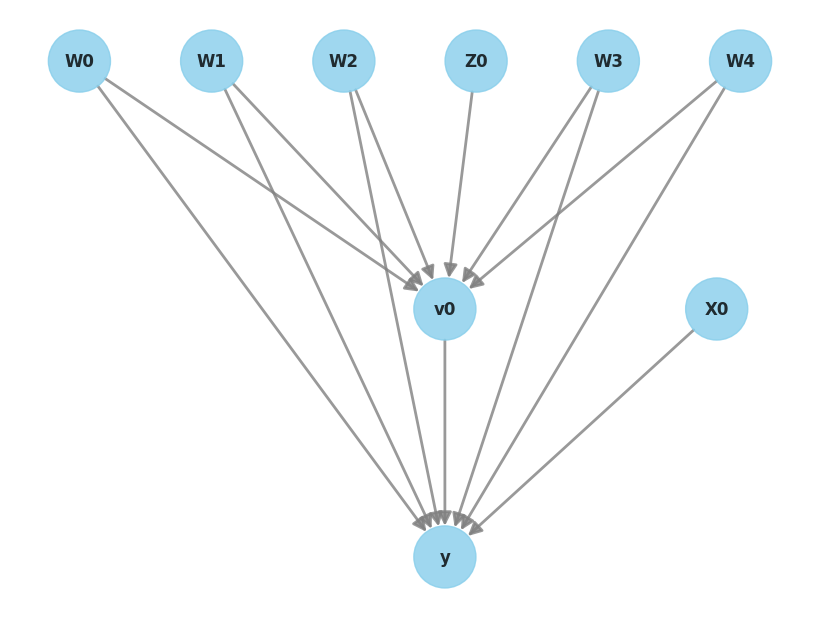

In [5]:
model.view_model()

You can then look into indentification of causal effect. In theory, you have to determine which causal estimand you are interested in, and then verify the identifiability assumptions: consistency, ignorability and positivity.

Alternatively, this step is implemented in the `DoWhy` package.

In [6]:
# identify the causal effect
identified_estimand = model.identify_effect(
    optimize_backdoor=True,
    proceed_when_unidentifiable=True)

In [7]:
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W2,W1,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W2,W1,W0,U) = P(y|v0,W3,W4,W2,W1,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                      -1⎤
 ⎢  d      ⎛  d        ⎞  ⎥
E⎢─────(y)⋅⎜─────([v₀])⎟  ⎥
 ⎣d[Z₀]    ⎝d[Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



The result of the method `identify_effect` confirms that the ATE is identified, and specifies the variables that need to be controlled for. We can now proceed with effect estimation.

## Estimation of the ATE with inverse propensity weighting
It is important to focus on the provided estimate, but also quantify the uncertainty of the estimation using confidence intervals.

In [8]:
estimate_ipw = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units = "ate",
    method_params={"weighting_scheme":"ips_stabilized_weight"},
    confidence_intervals="bootstrap")
print("ATE Estimate with IPW is {:.2f}, confidence interval: {}.".format(
    np.round(estimate_ipw.value, 2),
    np.round(estimate_ipw.get_confidence_intervals(), 2)))
# ATE Estimate is 10.13, confidence interval: [ 9.97 10.26].

ATE Estimate with IPW is 10.13, confidence interval: [ 9.66 10.64].


In [9]:
print(np.round(data['ate'], 2))

9.77


We see that the estimate is slightly off, but the confidence interval does  contain the true value of the ATE.

## Estimation with regression-based methods
We now test two approaches derived from the g-formula plugin estimator: the S-learner and the T-learner.

In [10]:
# S-Learner
estimate_s = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    confidence_intervals=True,
    method_params={
        'init_params': {
            'overall_model': LinearRegression()
        },
        'fit_params': {'inference': 'bootstrap'}
    })

ci_s = [c.mean() for c in estimate_s.get_confidence_intervals()]
print("Causal Estimate with the S-learner is {:.2f}, confidence interval: {}.".format(
    np.round(estimate_s.value, 2),
    np.round(ci_s, 2)))



# Get estimate (T-Learner)
estimate_t = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    confidence_intervals=True,
    method_params={
        'init_params': {
            'models': LinearRegression()
        },
        'fit_params': {'inference': 'bootstrap'}
    })

ci_t = [c.mean() for c in estimate_t.get_confidence_intervals()]
print("Causal Estimate with the T-learner is {:.2f}, confidence interval: {}.".format(
    np.round(estimate_t.value, 2),
    np.round(ci_t, 2)))


Causal Estimate with the S-learner is 9.77, confidence interval: [9.74 9.83].
Causal Estimate with the T-learner is 9.77, confidence interval: [9.77 9.78].


We see that the estimation is very accurate. The estimation from the T-learner has a smaller confidence interval in that case. Estimation works well because the dataset we consider is linear. If this is not the case, we may resort to more complex and robust estimators, such as the doubly-robust estimator, or the Double Machine learning estimator, both available in `DoWhy`, through `EconML`.

## Estimation with more advanced methods

In [11]:

drlearner_estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=True,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
ci_dr = [c.mean() for c in drlearner_estimate.get_confidence_intervals()]
print("Causal Estimate with the DR-learner is {:.2f}, confidence interval: {}.".format(
    np.round(drlearner_estimate.value, 2),
    np.round(ci_dr, 2)))


Causal Estimate with the DR-learner is 9.80, confidence interval: [9.73 9.87].
